# SHAP

#### Import the libraries

In [490]:
import xgboost
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [491]:
# load JS visualization code to notebook
shap.initjs()

#### Read the data

In [525]:
# read the data
df = pd.read_csv('../data/total_dry_no_info.csv', index_col=0)

/home/geanderson/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,4,5,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Normalize the dataset

In [526]:
# delete unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# convert all columns of DataFrame
df = df.dropna()
# find the objects columns
cols = df.columns[df.dtypes.eq('object')]
# convert to numeric these columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [527]:
df = df[df['language_Python'] == 1]

In [528]:
df.shape

(52617, 47)

In [529]:
df.drop('network_count', axis=1, inplace=True)
df.drop('forks', axis=1, inplace=True)
#df.drop('size', axis=1, inplace=True)
#df.drop('watchers', axis=1, inplace=True)
#df.drop('has_wiki', axis=1, inplace=True)

In [530]:
# dropping the columns that we do not need
#df.drop('language_C', axis=1, inplace=True)
#df.drop('language_C#', axis=1, inplace=True)
#df.drop('language_C++', axis=1, inplace=True)
#df.drop('language_CSS', axis=1, inplace=True)
#df.drop('language_CoffeeScript', axis=1, inplace=True)
#df.drop('language_Go', axis=1, inplace=True)
#df.drop('language_Java', axis=1, inplace=True)
#df.drop('language_JavaScript', axis=1, inplace=True)
#df.drop('language_PHP', axis=1, inplace=True)
#df.drop('language_Perl', axis=1, inplace=True)
#df.drop('language_Python', axis=1, inplace=True)
#df.drop('language_R', axis=1, inplace=True)
#df.drop('language_Ruby', axis=1, inplace=True)
#df.drop('language_Scala', axis=1, inplace=True)
#df.drop('language_Shell', axis=1, inplace=True)
#df.drop('language_TypeScript', axis=1, inplace=True)
#df.drop('network_count', axis=1, inplace=True)
#df.drop('forks', axis=1, inplace=True)

In [531]:
# separating X and y
cols = [col for col in df.columns if col not in ['mean_commits']]
X = df[cols]
y = df['mean_commits']

In [532]:
# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [533]:
# explain the model's predictions using SHAP values.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

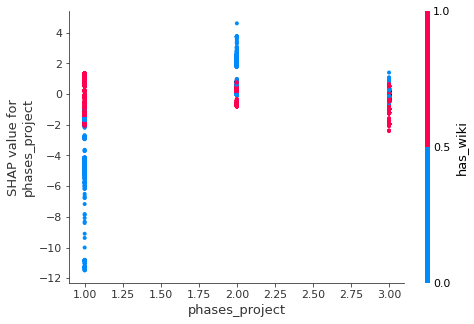

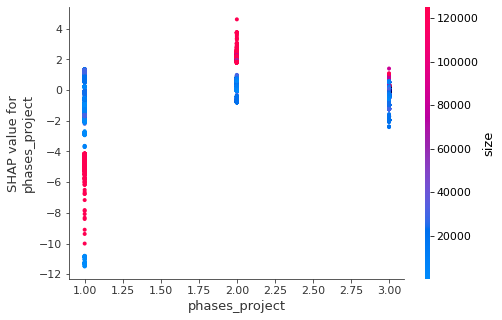

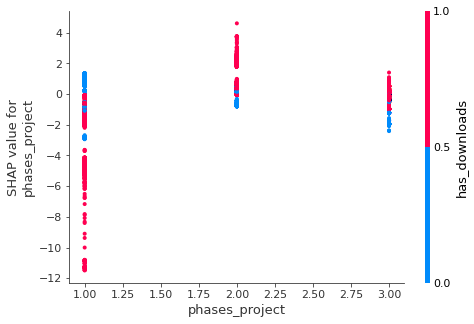

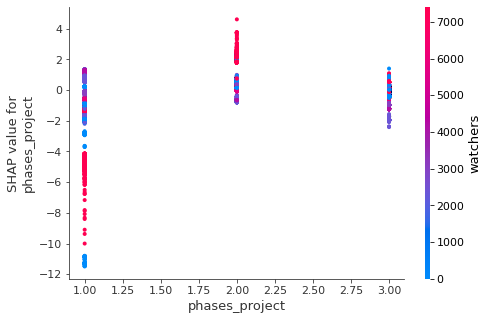

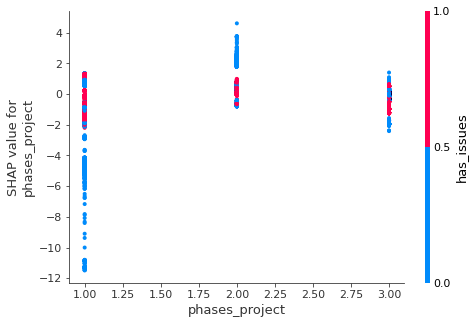

In [534]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("phases_project", shap_values, X)

# make plots colored by each of the top three possible interacting features
for i in range(5):
    shap.dependence_plot("phases_project", shap_values, X, interaction_index=inds[i])

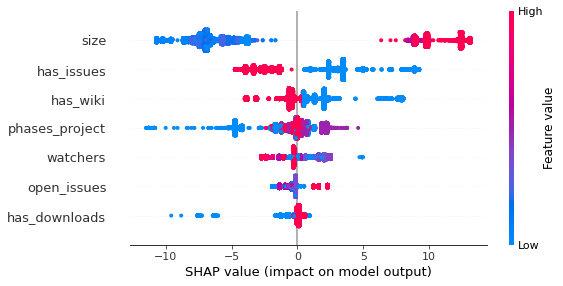

In [535]:
shap.summary_plot(shap_values, X, max_display=7)

In [547]:
def amortizacao(value):
    return value + 0.5

In [548]:
shap_v = pd.DataFrame(shap_values)
feature_list = X.columns
shap_v.columns = feature_list
df_v = X.copy()#.reset_index().drop('index',axis=1)
    
# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)

In [549]:
corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Variable','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

/home/geanderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'SHAP Value (Red = Positive Impact)')

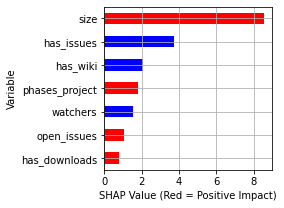

In [555]:
# Plot it
import seaborn as sns
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = True)
k3 = k2.tail(7)
colorlist = k3['Sign']
k3['SHAP_abs'] = k3['SHAP_abs'].apply(amortizacao)
ax = k3.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(3,3),legend=False)
ax.grid()
ax.set_xlabel("SHAP Value (Red = Positive Impact)")

#### That's all folks!!!